# nbjob

This file contains the core code for `nbjob`.

In [1]:
try:
    # When this file is run as part of the nbjob package, relative imports are allowed
    from .structs import Struct, impl, init
    from . import ipyparallel_display
    from .jobdb import make_default_dashboard, JobDB, Entry, Job, Analysis
except SystemError:
    # This file is a Jupyter notebook precisely to allow opening it in Jupyter
    # during development. Don't use relative imports here
    import notebook_import_hooks
    from nbjob_dev.structs import Struct, impl, init
    import nbjob_dev.ipyparallel_display
    from nbjob_dev.jobdb import make_default_dashboard, JobDB, Entry, Job, Analysis
    

Only nbjob developers should see this message.


### Hack to fix behavior of inspect module
See: https://bugs.python.org/issue12920

In [2]:
import inspect, sys

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)
    
    # Lookup by parent module
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__
    
    # If parent module is __main__, lookup by methods
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

## Remote functions for jobs and analyses

In [3]:
class DummyJobtracker():
    def checkpoint(self):
        pass
    
    def register_checkpointer(self, varname, gettername=None, settername=None):
        # Sanity check
        import __main__, pickle
        if gettername is not None:
            getter = eval(gettername, __main__.__dict__)
        else:
            getter = lambda: eval(varname, __main__.__dict__)

        if settername is not None:
            setter = eval(settername, __main__.__dict__)
        else:
            def setter(val):
                __main__.__dict__['_setter_proxy'] = val
                exec("{} = _setter_proxy".format(varname), __main__.__dict__)
                del __main__.__dict__['_setter_proxy']

        vals = getter()
        setter(pickle.loads(pickle.dumps(vals)))
        vals2 = getter()

In [4]:
def remote_create_job():
    """
    First entry point for code executed on the remote end
    
    This creates a job tracker and returns its job id to the main system
    """
    import bson, pickle
    # Job tracker class
    class JobTracker():
        def __init__(self, old_tracker=None):
            from pymongo import MongoClient
            import gridfs
            import socket, os, time, datetime, pwd
            self.client = MongoClient()
            self.entries = self.client.db.entries_test
            self.jobs = self.client.db.jobs_test
            self.fs = gridfs.GridFSBucket(self.client.db)
            self.checkpointers = []
            self.old_tracker = old_tracker
            
            login = pwd.getpwuid(os.getuid())[0]
            
            job = {
                    'name' : (time.strftime("%Y-%m-%dT%H:%M:%S") + "-" +
                              login + "@" + socket.gethostname() + ":" + str(os.getpid())),
                    'entry' : None,
                    'status' : 'Starting...',
                    'start_time' : datetime.datetime.now(),
                    'hostname' : socket.gethostname(),
                    'pid' : os.getpid(),
                    'user': login,
                    'stop_time' : None
                }

            self.job_id = self.jobs.insert_one(job).inserted_id # Tell others that we're online
            
        def set_records(self, **d):
            self.jobs.update_one({'_id': self.job_id},
                     {'$set': d})

        def start(self, entry_id):
            from bson.objectid import ObjectId
            self.entry = self.entries.find_one({'_id' : ObjectId(entry_id)})
            
            self.set_records(entry=self.entry['_id'])
        
        def finalize(self):
            import datetime
            self.set_records(stop_time=datetime.datetime.now())
        
        def change_status(self, new_status):
            print('NEW JOB STATUS:', new_status)
            self.set_records(status=new_status)

        def register_checkpointer(self, varname, gettername=None, settername=None):
            # Sanity check
            import __main__
            if gettername is not None:
                getter = eval(gettername, __main__.__dict__)
            else:
                getter = lambda: eval(varname, __main__.__dict__)

            if settername is not None:
                setter = eval(settername, __main__.__dict__)
            else:
                def setter(val):
                    __main__.__dict__['_setter_proxy'] = val
                    exec("{} = _setter_proxy".format(varname), __main__.__dict__)
                    del __main__.__dict__['_setter_proxy']

            vals = getter()
            setter(pickle.loads(pickle.dumps(vals)))
            vals2 = getter()
            #assert (vals == vals2)
            self.checkpointers.append((varname, gettername, settername))

        def checkpoint(self):
            # Perform any checkpoint operations
            print('Checkpointing!')
            
            varnames = []
            setternames = []
            
            grid_in = self.fs.open_upload_stream(
                '{}-{}.pkl'.format(self.job_id,
                                   self.entry['_id']))
            
            for varname, gettername, settername in self.checkpointers:
                if gettername is not None:
                    getter = eval(gettername)
                else:
                    getter = lambda: eval(varname)
                vals = getter()
                
                varnames.append(varname)
                setternames.append(settername)
                pickle.dump(vals, grid_in)
            
            grid_in.close()
            
            # Add an entry linking to the file in question
            d = {
                    'type' : 'file',
                    'names' : varnames,
                    'prev' : self.entry['_id'],
                    'setters' : setternames,
                    'file' : grid_in._id
                }
            
            new_id = self.entries.insert_one(d).inserted_id
            self.entry = self.entries.find_one({'_id' : new_id})

            # Add an actual checkpoint
            d = {
                    'type' : 'checkpoint',
                    'names' : [],
                    'prev' : self.entry['_id']
                }
            new_id = self.entries.insert_one(d).inserted_id
            self.entry = self.entries.find_one({'_id' : new_id})

            # Update the jobs queue
            self.set_records(entry=new_id)
    
    global _jobtracker
    
    # First, figure out if there is an old job tracker remaining
    old_tracker = None
    try:
        old_tracker = _jobtracker # TODO: better namespacing
    except:
        pass
    
    _jobtracker = JobTracker(old_tracker)
    
    return str(_jobtracker.job_id)

In [5]:
def remote_start_job(entry_id, run_commands, tracker_name=None):
    """
    Main entry point for code executed on the remote end
    
    entry_id: starting entry in the entry table, with which to begin execution
    run_commands: commands to run in the process of doing the job
    tracker_name: global name under which to expose the job tracker
    """
    global _jobtracker
    
    jobtracker = _jobtracker # Move it into the local namespace
    old_tracker = jobtracker.old_tracker
    
    jobtracker.start(entry_id)
    
    # Try to inherit information from the old job tracker. Otherwise, assume we are starting from scratch
    from bson.objectid import ObjectId
    
    current_entry_id = None
    if old_tracker:
        try:
            current_entry_id = old_tracker.entry['_id']
            if not isinstance(current_entry_id, ObjectId):
                current_entry_id = None
        except:
            pass

        try:
            jobtracker.checkpointers = old_tracker.checkpointers
        except:
            jobtracker.checkpointers = []
            
    # Let the old tracker be garbage-collected
    del old_tracker
    del jobtracker.old_tracker
    
    try:        
        # Figure out what history we need to replay
        jobtracker.change_status('Determining history to replay')
        seen = set()
        history = []
        ptr_entry = jobtracker.entry
        print("old entry id is", current_entry_id)
        # TODO: can't replay binary data here. Maybe we actually do want the ability for
        #       binary nodes here, such as for datasets
        while ptr_entry['_id'] != current_entry_id:
            if ptr_entry['type'] == 'src':
                names = set(ptr_entry['names'])
                do_add = True
                if None in names:
                    seen |= names
                elif names - seen:
                    seen |= names
                else:
                    # All names have already been seen, so skip populating history
                    do_add = False
                
                if do_add:
                    #print("adding history from entry", ptr_entry['_id'])
                    src = ptr_entry['src']
                    history.append(src)
                
            if ptr_entry['prev'] is None:
                history.append("%reset -f")
                break
            else:
                ptr_entry = jobtracker.entries.find_one({'_id':ptr_entry['prev']})

        _jobtracker = jobtracker
        if tracker_name is not None:
            globals()[tracker_name] = jobtracker
                
        history = history[::-1]

        jobtracker.change_status('Replaying history')
        for cell in history:
            #print('Running:', cell)
            res = get_ipython().run_cell(cell).raise_error()
            if cell.startswith("%reset"):
                # We just reset the namespace, so return jobtracker to it
                _jobtracker = jobtracker
                if tracker_name is not None:
                    globals()[tracker_name] = jobtracker

        jobtracker.change_status('Running commands')
        for cmd in run_commands:
            #print('Running:', cmd)
            res = get_ipython().run_cell(cmd).raise_error()
        
        jobtracker.change_status('Job complete')
        jobtracker.finalize()
    except KeyboardInterrupt:
        jobtracker.change_status('Killed')
        jobtracker.finalize()
        raise
    except Exception as e:
        # Best effort to notify of exception
        jobtracker.change_status('Terminated due to exception: {}'.format(e))
        jobtracker.finalize()
        raise

In [6]:
def remote_create_analyzer():
    """
    First entry point for code executed on the remote end
    
    This creates an analyzer and returns its analysis id to the main system
    """
    from bson.objectid import ObjectId
    
    # Job tracker class
    class AnalysisTracker():
        def __init__(self, old_tracker=None):
            from pymongo import MongoClient
            import gridfs
            import socket, os, time, datetime, pwd
            self.client = MongoClient()
            self.fs = gridfs.GridFSBucket(self.client.db)
            self.entries = self.client.db.entries_test
            self.analysis_entries = self.client.db.analysis_entries_test
            self.jobs = self.client.db.jobs_test
            self.analyses = self.client.db.analyses_test
            self.analyzers = []
            self.old_tracker = old_tracker
            
            login = pwd.getpwuid(os.getuid())[0]
            
            analysis = {
                    'name' : (time.strftime("%Y-%m-%dT%H:%M:%S") + "-" +
                              login + "@" + socket.gethostname() + ":" + str(os.getpid())),
                    'job' : None,
                    'analysis_entry' : None,
                    'status' : 'Starting...',
                    'start_time' : datetime.datetime.now(),
                    'hostname' : socket.gethostname(),
                    'pid' : os.getpid(),
                    'user': login,
                    'stop_time' : None
                }
            
            self.analysis_id = self.analyses.insert_one(analysis).inserted_id
            self.job_id = None
            
        def latest_entry_for_job(self):
            return self.entries.find_one(
                {'_id' : self.jobs.find_one({'_id' : self.job_id})['entry']})
        
        def set_records(self, **d):
            self.analyses.update_one({'_id': self.analysis_id},
                                     {'$set': d})
        
        def start(self, job_id):
            assert isinstance(job_id, str)
            self.analysis_entry = {'_id': None}
            
            self.job_id = ObjectId(job_id)
            self.set_records(job=self.job_id)
        
        def finalize(self):
            import datetime
            self.set_records(stop_time=datetime.datetime.now())
        
        def change_status(self, new_status):
            print('NEW ANALYSIS STATUS:', new_status)
            self.set_records(status=new_status)

        def register_analyzer(self, fn):
            # Sanity check
            res = fn()
            assert isinstance(res, dict)
            
            self.analyzers.append(fn)

        def analyze(self, checkpoint):
            # Perform any checkpoint operations
            assert isinstance(checkpoint, ObjectId)
            analysis_entry = {'checkpoint': checkpoint,
                             'prev' : self.analysis_entry['_id']}
            
            for fn in self.analyzers:
                analysis_entry.update(fn())

            new_id = self.analysis_entries.insert_one(analysis_entry).inserted_id
            self.analysis_entry = self.analysis_entries.find_one({'_id' : new_id})

            # Update the tracking info
            self.set_records(analysis_entry=new_id)
    
    global _analysistracker
    
    # First, figure out if there is an old job tracker remaining
    old_tracker = None
    try:
        old_tracker = _analysistracker # TODO: better namespacing
    except:
        pass
    
    _analysistracker = AnalysisTracker(old_tracker)
    
    return str(_analysistracker.analysis_id)

In [7]:
def remote_start_analyzer(job_id, analyzers, tracker_name=None, job_tracker_name=None):
    """
    Main entry point for code executed on the remote end
    
    entry_id: starting entry in the entry table, with which to begin execution
    run_commands: commands to run in the process of doing the job
    tracker_name: global name under which to expose the job tracker
    """
    global _analysistracker
    
    analysistracker = _analysistracker # Move it into the local namespace
    old_tracker = analysistracker.old_tracker
    
    analysistracker.start(job_id)
    
    # Try to inherit information from the old job tracker. Otherwise, assume we are starting from scratch
    from bson.objectid import ObjectId
    import pickle
    
    current_entry_id = None
    if old_tracker:
        try:
            current_entry_id = old_tracker.entry['_id']
            if not isinstance(current_entry_id, ObjectId):
                current_entry_id = None
        except:
            pass
            
    # Let the old tracker be garbage-collected
    del old_tracker
    del analysistracker.old_tracker
    
    # Dummy job tracker
    class DummyJobtracker():
        def checkpoint(self):
            pass
        def register_checkpointer(self, varname, gettername=None, settername=None):
            pass
    
    try:        
        # Figure out what history we need to replay
        analysistracker.change_status('Determining history to replay')
        
        ptr_entry = analysistracker.latest_entry_for_job()
        
        print("old entry id is", current_entry_id)
        
        all_histories = []
        current_history = []
        current_seen = set()
        last_checkpoint = None
        while ptr_entry is not None and ptr_entry['_id'] != current_entry_id:
            if ptr_entry['type'] in ('src', 'binary', 'file'):
                names = set(ptr_entry['names'])
                do_add = True

                if None in names:
                    current_seen |= names
                elif names - current_seen:
                    current_seen |= names
                else:
                    # All names have already been seen, so skip populating history
                    do_add = False

                if do_add:
                    current_history.append(ptr_entry['_id'])

            elif ptr_entry['type'] == 'checkpoint':
                if current_history and last_checkpoint:
                    all_histories.append((last_checkpoint, current_history[::-1]))
                last_checkpoint = ptr_entry['_id']
                current_history = []
                current_seen = set()
                
            if ptr_entry['prev'] is None:
                current_history.append("%reset -f")
                break
            else:
                ptr_entry = analysistracker.entries.find_one({'_id':ptr_entry['prev']},
                                                            {'src': False, 'data': False})

        _analysistracker = analysistracker
        if tracker_name is not None:
            globals()[tracker_name] = analysistracker
        if job_tracker_name is not None:
            globals()[job_tracker_name] = DummyJobtracker()
                
        all_histories = all_histories[::-1]
        current_history = current_history[::-1]
        
        if all_histories:
            # MAJOR HACK: this effective causes the first checkpoint to be ignored
            # but in reality, what we need is to have a system that selects the
            # checkpoints for which the analysis is valid
            temp = all_histories.pop(0)
            current_history.extend(temp[1])
            
        def replay_cell(cell):
            global _analysistracker
            global _setter_proxy
            
            if isinstance(cell, str):
                res = get_ipython().run_cell(cell).raise_error()
            else: # if cell is an id
                ptr_cell = analysistracker.entries.find_one({'_id': cell})
                if ptr_cell['type'] == 'src':
                    cell = ptr_cell['src']
                    get_ipython().run_cell(cell).raise_error()
                elif ptr_cell['type'] == 'binary':
                    settername = ptr_cell['setter']
                    if settername is not None:
                        setter = globals()[settername]
                        data = pickle.loads(ptr_cell['data'])
                        setter(data)
                    else:
                        varname = list(ptr_cell['names'])[0]
                        _setter_proxy = pickle.loads(ptr_cell['data'])
                        get_ipython().run_cell("{} = _setter_proxy".format(varname)).raise_error()
                        del _setter_proxy
                elif ptr_cell['type'] == 'file':
                    grid_out = _analysistracker.fs.open_download_stream(ptr_cell['file'])
                    
                    for varname, settername in zip(ptr_cell['names'], ptr_cell['setters']):
                        if settername is not None:
                            setter = globals()[settername]
                            data = pickle.load(grid_out)
                            setter(data)
                        else:
                            _setter_proxy = pickle.load(grid_out)
                            get_ipython().run_cell("{} = _setter_proxy".format(varname)).raise_error()
                            del _setter_proxy
                    grid_out.close()

            if isinstance(cell, str) and cell.startswith("%reset"):
                # We just reset the namespace, so return jobtracker to it
                _analysistracker = analysistracker
                if tracker_name is not None:
                    globals()[tracker_name] = analysistracker
                if job_tracker_name is not None:
                    globals()[job_tracker_name] = DummyJobtracker()
        
        analysistracker.change_status('Replaying initial history')
        for cell in current_history:
            replay_cell(cell)
        
        analysistracker.change_status('Registering analyzers')
        for analyzer in analyzers:
            analysistracker.register_analyzer(analyzer)

        analysistracker.change_status('Replaying history for checkpoints')
        for checkpoint, history in all_histories:
            for cell in history:
                replay_cell(cell)
            
            # Then do snapshotting
            analysistracker.analyze(checkpoint)
        
        analysistracker.change_status('Analysis complete')
        analysistracker.finalize()
    except KeyboardInterrupt:
        analysistracker.change_status('Killed')
        analysistracker.finalize()
        raise
    except Exception as e:
        # Best effort to notify of exception
        analysistracker.change_status('Terminated due to exception: {}'.format(e))
        analysistracker.finalize()
        raise

In [8]:
# Hacks so these functions are serialized correctly by the ipyparallel system
remote_create_job.__module__  = '__main__'
remote_start_job.__module__  = '__main__'
remote_create_analyzer.__module__  = '__main__'
remote_start_analyzer.__module__  = '__main__'

## SnippetCollector

In [9]:
class SnippetCollector(metaclass=Struct):
    def __call__(self, *args, **kwargs): # Special methods currently not supported by structs
        return self._call(*args, **kwargs)

In [10]:
def make_copy(other, shallow=True):
    if isinstance(other, SnippetCollector):
        history = other.history
    else:
        history = other
    res = SnippetCollector()
    
    if not shallow:
        history = [(k.copy(), v) for k,v in history]
    
    res.history = history
    return res
SnippetCollector.make_copy = make_copy

In [11]:
@impl(SnippetCollector)
def _call(self, a):
    if '.' in a.__qualname__:
        raise Exception('Cannot decorate an inner function or class')
    
    src = inspect.getsource(a)
    if src.startswith("@"):
        src = "def" + src.split("def", 1)[1]

    self.history.append((set([a.__name__]), src))
    return a

In [12]:
@init(SnippetCollector)
def _(self):
    self.history = []
    self.shell = get_ipython()

In [13]:
@impl(SnippetCollector)
def collect(self, src, names=()):
    self.history.append((set(names) | set([None]), src))

In [14]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def snip(line, cell):
    import __main__
    snippet_collector = getattr(__main__, line)
    if not isinstance(snippet_collector, SnippetCollector):
        raise ValueError("{} is not a SnippetCollector".format(line))
    
    get_ipython().run_cell(cell).raise_error()
    
    snippet_collector.collect(cell)

In [15]:
@impl(SnippetCollector)
def compact(self):
    seen = set()
    for i in range(len(self.history)-1, -1, -1): # Reverse iterate over history
        names = self.history[i][0]
        if None in names:
            seen |= names
            continue
        elif names - seen:
            seen |= names
            continue
        else:
            # All names have been seen
            self.history.pop(i)

## ParamLogger

In [16]:
import IPython.display
import ipywidgets

In [17]:
class ParamLogger():
    allowed_types = [int, float, str, bool]
    def __init__(self):
        self._r_params = {}
    
    def __getattr__(self, name):
        if name.startswith('_'):
            return object.__getattribute__(self, name)
        
        res = [False, False, None]
        def cont(accept, val):
            res[:] = True, accept, val
        
        box = ipywidgets.VBox(children = [
            ipywidgets.HTML(value="Select a value for parameter {}".format(name)),
            ipywidgets.IntSlider(max=15),
            ipywidgets.HBox(children = [
                    ipywidgets.Button(description='Done'),
                    ipywidgets.Button(description='Cancel'),
                ]),
        ])
        box.children[-1].children[0].on_click(lambda _: cont(True, box.children[1].value))
        box.children[-1].children[1].on_click(lambda _: cont(False, _))
        IPython.display.display(box)
        
        while not res[0]:
            get_ipython().kernel.do_one_iteration()
            
        box.close()
            
        if res[1]:
            setattr(self, name, res[2])
            return res[2]
        
        return object.__getattribute__(self, name)
    
    def __setattr__(self, name, value):
        if name.startswith('_r_'):
            return object.__setattr__(self, name, value)
        
        if type(value) not in ParamLogger.allowed_types:
            raise ValueError('Parameter type {} not allowed'.format(type(value)))

        self._r_params[name] = repr(value)
        
        return object.__setattr__(self, name, value)
    
    def dump(self, varname):
        keys = sorted(self._r_params.keys())
        return """
class _ParamContainer(object): pass
{varname} = _ParamContainer()
""".format(varname=varname) + ''.join(["""
{varname}.{key} = {value}""".format(varname=varname, key=key, value=self._r_params[key]) for key in keys])
    
    def clone_widget(self):
        box = ipywidgets.VBox()
        abbreviations = [(k, eval(v), None) for k,v in self._r_params.items() ]

        def reset():
            box.children = ipywidgets.interaction._widgets_from_abbreviations(abbreviations)
        
        def accept():
            res = ParamLogger()
            for child in box.children:
                k = child._kwarg
                v = child.value
                setattr(res, k, v)
            return res
        
        reset()
        
        return box, accept, reset
    
    def interactive_clone(self):
        w, accept, reset = self.clone_widget()
        
        done = [False]
        result = [None]
        def act_ok(_):
            done[0] = True
            result[0] = accept()
            
        def act_cancel(_):
            done[0] = True
        
        b_ok = ipywidgets.Button(description='OK')
        b_ok.on_click(act_ok)
        b_reset = ipywidgets.Button(description='Reset')
        b_reset.on_click(lambda _: reset)
        b_cancel = ipywidgets.Button(description='Cancel')
        b_cancel.on_click(act_cancel)

        buttons = ipywidgets.HBox(children=[b_ok, b_reset, b_cancel])

        container = ipywidgets.VBox(children=[buttons, w, buttons])
        IPython.display.display(container)
        while not done[0]:
            get_ipython().kernel.do_one_iteration()

        container.close()

        result = result[0]
        if result is None:
            raise Exception('Cancelled by user')

        return result

## Widgets for cloning/combining SnippetCollectors

In [18]:
@impl(SnippetCollector)
def clone_widget(self):
    self.compact()
    
    container = ipywidgets.VBox()
    
    cells = []
    ctrls = []
    records = []
    
    def generate_cells():
        cells.clear()
        ctrls.clear()
        
        self.compact()

        for i, (_, src) in enumerate(self.history):
            ctrl = ipywidgets.ToggleButtons(options=['keep', 'ign', 'del'])
            text = ipywidgets.HTML(value="<pre>{}</pre>".format(src))
            text.width='800px'
            ctrl.padding = '0 10px 0 0'
            cells.append(ipywidgets.HBox(children=[ctrl, text]))
            ctrls.append(ctrl)
            
        container.children = cells
    
    def accept(shallow=True):
        res = []
        for i, (names, src) in enumerate(self.history):
            if ctrls[i].value == 'keep':
                res.append((names, src))
            elif ctrls[i].value == 'del':
                names.clear()
        generate_cells()
        return SnippetCollector.make_copy(res, shallow=shallow)
    
    generate_cells()
    
    return container, accept, generate_cells

In [19]:
def interactive_combine(*snippets, **params):
    """
    Interactively combine snippet collectors
    
    snippets: snippet collectors to combine
    params: key is the variable name to assign the parameters under
            value is the dictionary of parameter names to values
    """
    new_sc = SnippetCollector()
    
    param_cells = []
    param_accepts = {}
    param_resets = []
    for k, v in params.items():
        w, a, r = v.clone_widget()
        param_cells.append(ipywidgets.HBox(children=[
                ipywidgets.HTML(value='{}'.format(k)),
                w
            ]))
        param_accepts[k] = a
        param_resets.append(r)
    param_cells = ipywidgets.VBox(children=param_cells)
    
    for sc in snippets:
        new_sc.history.extend(sc.history)
    
    cells, accept, reset = new_sc.clone_widget()
    
    done = [False]
    result = [None]
    
    c_deep = ipywidgets.Checkbox(description='Deep copy')
    
    def act_ok(_):
        done[0] = True
        result[0] = accept(shallow = (not c_deep.value))
        param_history = []
        for k in sorted(param_accepts.keys()):
            v = param_accepts[k]
            param_history.append((set([k]), v().dump(k)))
        result[0].history = param_history + result[0].history #HACK
    
    def act_reset(_):
        for r in param_resets:
            r()
        reset()
    
    def act_cancel(_):
        done[0] = True
    
    b_ok = ipywidgets.Button(description='OK')
    b_ok.on_click(act_ok)
    b_reset = ipywidgets.Button(description='Reset')
    b_reset.on_click(act_reset)
    b_cancel = ipywidgets.Button(description='Cancel')
    b_cancel.on_click(act_cancel)
    
    buttons = ipywidgets.HBox(children=[b_ok, b_reset, b_cancel])
    
    container = ipywidgets.VBox(children=[c_deep, buttons, param_cells, cells, c_deep, buttons])
    IPython.display.display(container)
    while not done[0]:
        get_ipython().kernel.do_one_iteration()
        
    container.close()
    
    result = result[0]
    if result is None:
        raise Exception('Cancelled by user')
    
    return result
SnippetCollector.interactive_combine = interactive_combine

In [20]:
@impl(SnippetCollector)
def interactive_clone(self):
    return SnippetCollector.interactive_combine(self)

## DBWrapper

In [21]:
class DBWrapper(metaclass=Struct):
    def __init__(self, *args, **kwargs):
        self.jobdb = JobDB(*args, **kwargs)

## JobRunner

In [22]:
class JobRunner(metaclass=Struct):
    def __init__(self, worker, entry, cmds, tracker_name='jobtracker'):
        self.entry = entry
        self.tracker_name = tracker_name
        self.worker = worker
        if isinstance(cmds, str):
            self.cmds = [cmds]
        else:
            self.cmds = cmds
        
        self.result = None
        self.job = None
        self.run()

In [23]:
@impl(JobRunner)
def run(self):
    global remote_create_job, remote_start_job
    b = self.worker.block
    
    self.worker.clear()
    
    self.worker.block = True
    print("Creating remote job")
    job_id = self.worker.apply(remote_create_job)
    self.job = Job(self.entry.jobdb, job_id)

    self.worker.block = False
    print("Running remote job")
    self.result = self.worker.apply(remote_start_job, str(self.entry._id), self.cmds, tracker_name=self.tracker_name)
    
    self.worker.block = b

In [24]:
@impl(DBWrapper)
def create_job(self, worker, cmds, *snippets, **params):
    sc = SnippetCollector.interactive_combine(*snippets, **params)
    sc = sc.make_copy(shallow=False)
    sc.compact()
    
    entry = Entry(self.jobdb).new(sc.history)

    return JobRunner(worker, entry, cmds, tracker_name='jobtracker')

## AnalysisRunner

In [25]:
class AnalysisRunner(metaclass=Struct):
    def __init__(self, worker, job, analyzers, tracker_name='analysistracker',
                 job_tracker_name='jobtracker'):
        if isinstance(job, JobRunner):
            job = job.job
        
        self.job = job
        self.tracker_name = tracker_name
        self.job_tracker_name = job_tracker_name
        self.worker = worker
        self.analyzers = analyzers
        
        self.result = None
        self.analysis = None
        self.run()

In [26]:
@impl(AnalysisRunner)
def run(self):
    global remote_create_analyzer, remote_start_analyzer
    b = self.worker.block
    
    self.worker.clear()
    
    self.worker.block = True
    analysis_id = self.worker.apply(remote_create_analyzer)
    self.analysis = Analysis(self.job.jobdb, analysis_id)

    self.worker.block = False
    self.result = self.worker.apply(remote_start_analyzer,
                                    str(self.job._id),
                                    self.analyzers,
                                    tracker_name=self.tracker_name,
                                    job_tracker_name=self.job_tracker_name,)
    
    self.worker.block = b

In [27]:
@impl(AnalysisRunner)
def get_results(self):
    return list(self.analysis.results)

In [28]:
@impl(DBWrapper)
def create_analyzer(self, worker, job, analyzers):
    return AnalysisRunner(worker, job, analyzers, tracker_name='analysistracker', job_tracker_name='jobtracker')

In [ ]:
# The magic string below signals to the notebook importing machinery that
# the examples section below should not be imported into any other modules

#NBIMPORT_STOP

# Examples
For actual documentation and tutorial, see the `doc/` folder, or browse the latest documentation online at http://nikitakitaev.com/nbjob

In [59]:
make_default_dashboard()

In [29]:
import ipyparallel as ipp
rc = ipp.Client()

In [30]:
rc[:]

<DirectView [0, 1, 2, 3,...]>

In [31]:
import IPython.display

In [32]:
sc = SnippetCollector()

In [33]:
hparams = ParamLogger()

In [34]:
hparams.max_x = 15

In [35]:
jobtracker = DummyJobtracker()

In [36]:
%%snip sc
def get_y():
    global y
    return y
def set_y(val):
    global y
    y = val

In [37]:
%%snip sc
x = 0
y = 0
jobtracker.register_checkpointer('x')
jobtracker.register_checkpointer('y', 'get_y', 'set_y')

In [38]:
%%snip sc
x=1
y=1
jobtracker.checkpoint()
for x in range(hparams.max_x):
    y = x ** 2
    jobtracker.checkpoint()

In [39]:
db_wrapper = DBWrapper()

In [40]:
worker = rc[15]

In [41]:
job = db_wrapper.create_job(worker,
                            ['import time; time.sleep(5)'],
                            sc,
                           hparams=hparams,)
job.result

Creating remote job
Running remote job


<AsyncResult: remote_start_job>

In [42]:
def a():
    global x, y
    return {'x':x, 'y':y}
analyzer = db_wrapper.create_analyzer(worker, job, [a])
analyzer.result

<AsyncResult: remote_start_analyzer>

RemoteError: KeyError('_37466827f2cb4196b04a7729075e9e51_kwargs')

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline

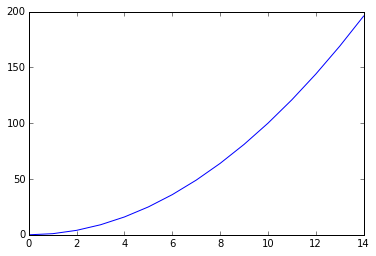

In [44]:
xs = []
ys = []
for d in analyzer.get_results():
    #print(d)
    xs.append(d['x'])
    ys.append(d['y'])

plt.plot(xs, ys)

In [54]:
worker.activate('_a')

In [55]:
%%px_a
x, y

Out[15:3]: (14, 196)

<AsyncResult: execute>

In [56]:
worker['x']

14

In [57]:
x = 5
worker.apply(lambda z: x+z, 1)

15

<AsyncResult: finished>